In [40]:
%matplotlib inline

from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML

import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
from scipy.integrate import odeint

import pandas as pd

#from scipy.integrate import odeint
import math
#from mpl_toolkits.mplot3d import Axes3D
#from math import hypot
from scipy import optimize
import warnings
warnings.filterwarnings("ignore")
import copy
from datetime import datetime   # useful for date ranges in plots

#import os
#os.chdir ('C:\\Users\\odiao\\Desktop\\Model Covid19\\programme_python\\SHR_PA\Code_Python')
#os.getcwd ()

In [54]:
sw_dataset = 'UK'  # !! Default: 'BEL'. Currently 'BEL' and 'FRA' 'LUX'and 'UK'are available.
sw_districts = 'sum'  # !! Default: 'sum'. If 'sum', sums over all districts (i.e., provinces, departments...). If 'each', loop over all districts. sw_districts can also be the name of a district (for example, sw_districts = 'Brussels', or sw_districts = '75' for Paris).

show_totinout = 1  # Default: 0 # If 1, shows plots of total, in and out and check their discrepancy.
save_figures = 0  # If 1, some figures will be saved in pdf format.

show_figures = 1  # If 0, no figure shown. Will be set to 0 later on if nb_districts too large.
show_hist = 0
show_H = 1  # If 1, draw a plot of the evolution of H(t).
show_S_bar = 1
show_beta_bar = 1
show_gamma = 1

In [55]:
# ***********************************************************************************
# Load data Belgium
#**********************************************************
data_url = '/COVID19BE_HOSP_2020-07-16.csv'
if sw_dataset == 'BEL':
    # The data comes from https://epistat.sciensano.be/Data/COVID19BE_HOSP.csv.
    # This link was provided on 22 June 2020 by Alexey Medvedev on the "Re R0 estimation" channel of the O365G-covidata team on MS-Teams.
    # The link can be reached from https://epistat.wiv-isp.be/covid/
    # Some explanations can be found at https://epistat.sciensano.be/COVID19BE_codebook.pdf

    data_raw = pd.read_csv(data_url)
    #fields = ['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']

    if sw_districts == 'each':
        data_groupbydistrict = pd.DataFrame(data_raw.groupby("PROVINCE"))
# ***********************************************************************************
# Load data French
#**********************************************************
data_url = '/donnees-hospitalieres-covid19-2020-07-17-19h00_corrected.csv'
if sw_dataset == 'FRA':
    # The data comes from https://www.data.gouv.fr/en/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/, see donnees-hospitalieres-covid19-2020-07-10-19h00.csv

    data_raw = pd.read_csv(data_url)  # some dates were not in the correct format, hence the "corrected" version of the csv file
    data_raw = data_raw[data_raw.iloc[:,1]==0].reset_index(drop=True)  # Discard sex "1" and "2" (i.e., only keep sex "0" which is the sum of females and males) and reset the index in order to have a contiguous index in the DataFrame.

    if sw_districts == 'each':
        data_groupbydistrict = pd.DataFrame(data_raw.groupby("dep"))
# ***********************************************************************************
# Load data Luxembourg
#**********************************************************
if sw_dataset == 'LUX':
    # The data comes from https://www.data.gouv.fr/en/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/, see donnees-hospitalieres-covid19-2020-07-10-19h00.csv

    data_raw = pd.read_csv('Data/Luxembourg/data_lux.csv')  # some dates were not in the correct format, hence the "corrected" version of the csv file
    #data_raw = data_raw[data_raw.iloc[:,1]==0].reset_index(drop=True)  # Discard sex "1" and "2" (i.e., only keep sex "0" which is the sum of females and males) and reset the index in order to have a contiguous index in the DataFrame.
    data_groupbydistrict=pd.DataFrame(data_raw.groupby("Date"))

# ***********************************************************************************
# Load data United kingdom
#**********************************************************
data_url = '/data_UK.csv'
if sw_dataset == 'UK':
    # The data comes from https://www.data.gouv.fr/en/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/, see donnees-hospitalieres-covid19-2020-07-10-19h00.csv

    data_raw = pd.read_csv(data_url)  # some dates were not in the correct format, hence the "corrected" version of the csv file
    #data_raw = data_raw[data_raw.iloc[:,1]==0].reset_index(drop=True)  # Discard sex "1" and "2" (i.e., only keep sex "0" which is the sum of females and males) and reset the index in order to have a contiguous index in the DataFrame.
    data_groupbydistrict=pd.DataFrame(data_raw.groupby("date"))

In [ ]:
confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')

confirmed_cases
data_end   = '7/15/20' #Take the data until yesterday
data_begin = '3/15/20'
cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == "Belgium", data_begin:data_end])[0]

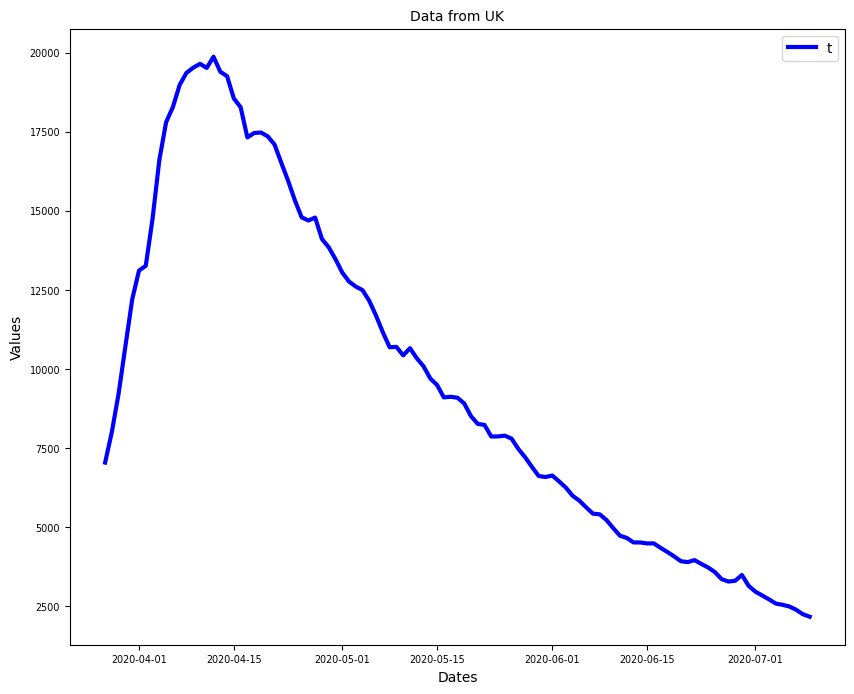

In [56]:
#*********************************
# Start loop on districts
# *******
if sw_districts == 'sum':
    nb_districts = 1
elif sw_districts == 'each':
    nb_districts = len(data_groupbydistrict)
else:  # else nb_districts is the name of a district
    nb_districts = 1

if nb_districts > 2:
    show_figures = 0  # Force figures off if there are too many districts

for cnt_district in range(nb_districts):

    if sw_districts == 'sum':
        district_name = 'sum'
        district_names = np.array(['sum'])   # without np.array, we get an error in district_names[medians_argsort]
    elif sw_districts == 'each':
        district_name = data_groupbydistrict[0][cnt_district]
        district_names = data_groupbydistrict[0]
    else:
        district_name = sw_districts
        district_names = np.array([sw_districts])
    # ***********************************************************************************
    # Process data Belgium
    # *******
    if sw_dataset == 'BEL':

        if sw_districts == 'sum':
            data_raw_district = data_raw.groupby('DATE', as_index=False).sum()  # sum over provinces
        elif sw_districts == 'each':
            data_raw_district = data_groupbydistrict[1][cnt_district]  # extract province cnt_district
        else:
            data_raw_district = data_raw[data_raw.iloc[:,1]==sw_districts].reset_index(drop=True)   # extract district with name sw_districts

        data = data_raw_district[['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']]  # exclude some useless columns

        # Extract relevant data and recompute new_out:
        # Source: Some variable names taken from https://rpubs.com/JMBodart/Covid19-hosp-be
        data_length = np.size(data,0)
        data_num = data.iloc[:,1:].to_numpy(dtype=float)  # extract all rows and 2nd-last rows (recall that Python uses 0-based indexing) and turn it into a numpy array of flats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

        #dates = data['DATE'])
        dates_raw = copy.deepcopy(data['DATE'])
        dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
        dates = [None] * data_length
        for i in range(0,data_length):
            dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

        col_total_in = 1
        col_new_in = 5
        col_new_out = 6
        total_in = data_num[:,col_total_in]
        new_in = data_num[:,col_new_in]
        new_out_raw = data_num[:,col_new_out] # there will be a non-raw due to the "Problem" mentioned below.
        new_delta = new_in - new_out_raw
        cum_new_delta = np.cumsum(new_delta)
        total_in_chg = np.hstack(([0],np.diff(total_in))) #difference between x[i+1]-x[i]
        # Problem: new_delta and total_in_chg are different, though they are sometimes close.
        # Cum_new_delta does not go back to something close to zero, whereas it should. Hence I should not trust it.
        # I'm going to trust total_in and new_in. I deduce new_out_fixed by:
        new_out = new_in - total_in_chg   # fixed new_out
        data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns
        reported_cases = data_num[:,0]

        # Show Belgian data in figures:

        if show_figures & show_totinout:
            nb_xticks = 4
            dates_ticks = [None] * nb_xticks
            dates_ticks_ind = np.linspace(0,len(total_in)-1,nb_xticks,dtype=int)
            for i in range(0,nb_xticks):
                dates_ticks[i] = dates[dates_ticks_ind[i]]
            fig=plt.figure(figsize=(16,8))

            plt.subplot(2,2,1)
            plt.plot(dates[:len(np.diff(cases_obs))], np.diff(cases_obs), label="Confirmed_cases")
            #plt.xlabel("Dates")
            plt.ylabel("Values")
            plt.xticks(dates_ticks)
            plt.legend()
            plt.title("A")

            plt.subplot(2,2,2)
            plt.plot(dates, total_in)
            plt.plot(dates,cum_new_delta)
            #plt.xlabel("Dates")
            plt.ylabel("Values")
            plt.xticks(dates_ticks)
            plt.legend(("total_in","cum_new_delta"))
            plt.title("B")
            #plt.ylim([0,1000])

            plt.subplot(2,2,3)
            plt.plot(dates,new_delta)
            plt.plot(dates,total_in_chg)
            plt.xlabel("Dates")
            plt.ylabel("Values")
            plt.title("C")
            plt.xticks(dates_ticks)
            plt.legend(("new_delta","total_in_chg"))

            plt.subplot(2,2,4)
            plt.plot(dates,new_out_raw)
            plt.plot(dates,new_out)
            plt.xticks(dates_ticks)
            plt.xlabel("Dates")
            plt.title("D")
            plt.legend(("new_out_raw","new_out"))

            plt.show(block=False)  # block=False does not block the execution of the script
        # end if show_totinout
        #fig.savefig('C:/Users/odiao/Desktop/Redaction_darticles_Latex/SHR_PA/Figures/data_BEL_bis.eps')   # save the figure to file
        #plt.close(fig)
    # ***********************************************************************************
    # Process data France
    # *******

    elif sw_dataset == 'FRA':  # if sw_datset is 'FRA'

        if sw_districts == 'sum':
            data_raw_district = data_raw.groupby('jour', as_index=False).sum()  # sum over identical dates
        elif sw_districts == 'each':
            data_raw_district = data_groupbydistrict[1][cnt_district]  # extract department cnt_district
        else:
            data_raw_district = data_raw[data_raw.iloc[:,0]==sw_districts].reset_index(drop=True)   # extract district with name sw_districts

        data = data_raw_district[['jour','hosp','rea','rad','dc']]  # exclude some useless columns

        # Extract relevant data and recompute new_in:
        data_length = np.size(data,0)
        data_num = data.iloc[:,1:].to_numpy(dtype=float)  # extract all rows and 2nd-last rows (recall that Python uses 0-based indexing) and turn it into a numpy array of flats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

        #dates = data['DATE'])
        dates_raw = copy.deepcopy(data['jour'])
        dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
        dates = [None] * data_length
        for i in range(0,data_length):
            dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

        col_total_in = 0
        col_new_in = np.nan   # no column for new_in in French data
        col_new_out = np.nan  # to get new_out we have to sum 'rad' and 'dc'
        total_in = data_num[:,col_total_in]
        new_out = np.hstack(([0],np.diff(data_num[:,2] + data_num[:,3])))
        total_in_chg = np.hstack(([0],np.diff(total_in)))
        new_in = new_out + total_in_chg
        data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns
        #Plot total_in
        plt.figure(figsize=(10,8))
        plt.plot(dates, total_in, 'b', lw=3)
        plt.xlabel("Dates")
        plt.ylabel("Values")
        plt.legend("total_in")
        plt.title("Data from French", size=10)
        plt.show()
        # end if sw_dataset

    # ***********************************************************************************
    # Process data Luxembourg
    # *******

    elif sw_dataset == 'LUX':  # if sw_datset is 'FRA'

        data = data_raw[['hospi', 'hospintense', 'sortant']]  # exclude some useless columns

        # Extract relevant data and recompute new_in:
        data_length = np.size(data,0)
        data_num = data.iloc[:,].to_numpy(dtype=float)  # extract all rows and 2nd-last rows (recall that Python uses 0-based indexing) and turn it into a numpy array of flats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

        #dates = data['DATE'])
        dates_raw = copy.deepcopy(data_raw['Date'])
        dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
        dates = [None] * data_length
        for i in range(0,data_length):
            dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

        col_total_in = 0
        col_new_out = 2  # to get new_out with 'sortant'
        total_in = data_num[:,col_total_in]
        new_out = data_num[:,col_new_out]
        total_in_chg = np.hstack(([0],np.diff(total_in)))
        new_in = new_out + total_in_chg
        data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns

        #Plot total_in
        fig=plt.figure(figsize=(10,8))
        plt.plot(dates, total_in, 'b', lw=3)
        plt.xlabel("Dates")
        plt.ylabel("Values")
        plt.legend("total_in")
        plt.title("Data from Luxembourg", size=10)
        plt.show()

    # ***********************************************************************************
    # Process data United kingdom
    # *******

    elif sw_dataset == 'UK':  # if sw_datset is 'FRA'

        data = data_raw[['newAdmissions', 'Hospi']]  # exclude some useless columns

        # Extract relevant data and recompute new_in:
        data_length = np.size(data,0)
        data_num = data.iloc[:,].to_numpy(dtype=float)  # extract all rows and 2nd-last rows (recall that Python uses 0-based indexing) and turn it into a numpy array of flats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

        #dates = data['DATE'])
        dates_raw = copy.deepcopy(data_raw['date'])
        dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
        dates = [None] * data_length
        for i in range(0,data_length):
            dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

        col_total_in = 1
        col_new_in = 0  # to get new_out with 'sortant'
        total_in = data_num[:,col_total_in]
        new_in = data_num[:,col_new_in]
        total_in_chg = np.hstack(([0],np.diff(total_in)))
        new_out = new_in - total_in_chg
        data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns

        #Plot total_in
        fig=plt.figure(figsize=(10,8))
        plt.plot(dates, total_in, 'b', lw=3)
        plt.xlabel("Dates")
        plt.ylabel("Values")
        plt.legend("total_in")
        plt.title("Data from UK", size=10)
        plt.show()

In [ ]:
# ***********************************************************************************
# Select train and test periods
# *******

#sw_periods = '1.2.60'   # !!
# '0.1': train over the whole data
# '1.01': train period around the peak chosen "by hand" for BEL
# '1.02': a few train periods around the peak chosen "by hand" for BEL
# '1.1.60': put train period around peak WITH data leakage - do not use
# '1.2.60': train period around the peak, selected automatically without data leakage
# '2.1': train period around the end
# '3.1': sliding train window, test until end
# "3.1.60': sliding train window, test duration 60

#if sw_periods == '0.1':
# One large train:  *keep*-with c_E=c_L=0, only show_H
train_t_start_vals = np.array([1]);
train_t_end_vals = (len(total_in)-0) * np.ones(np.shape(train_t_start_vals),dtype=int);
test_t_end_vals = (len(total_in)-0) * np.ones(np.shape(train_t_start_vals),dtype=int);

In [ ]:
#Train period of 14 days from the beginning
train_t_start_vals = np.array([0])
train_t_end_vals = train_t_start_vals + 14;  # + 14 for 14 days in train period
test_t_end_vals = (len(total_in)-0) * np.ones(np.shape(train_t_start_vals),dtype=int);

In [65]:

# Around the peak of UK
train_t_start_vals = np.array([7])
train_t_end_vals = train_t_start_vals + 14;  # + 14 for 14 days in train period
test_t_end_vals = (len(total_in)-0) * np.ones(np.shape(train_t_start_vals),dtype=int);

In [57]:
#if sw_periods == '1.01':
# This one gives a MAPE_test of 7.9% for Belgium
train_t_start_vals = np.array([18])
train_t_end_vals = train_t_start_vals + 14;  # + 14 for 14 days in train period
test_t_end_vals = (len(total_in)-0) * np.ones(np.shape(train_t_start_vals),dtype=int);

In [ ]:
#if sw_periods == '1.02':
# A few small trains:  *keep*-only show_H show_S
#train_t_start_vals = np.array([10,12,14,16,18,20,22])
train_t_start_vals = np.arange(16,22,2) #for Belgium, French
train_t_start_vals = np.arange(8,22,4) #for UK and Luxembourg because the peak rapidely obtained
train_t_end_vals = (32) * np.ones(np.shape(train_t_start_vals),dtype=int)
#train_t_end_vals = train_t_start_vals + 14
test_t_end_vals = (len(total_in)-0) * np.ones(np.shape(train_t_start_vals),dtype=int)

In [ ]:
#if sw_periods == '1.1.60':  # put train period around peak WITH data leakage
N = 7  # The window length of moving average will be 2N+1.
total_in_MA = total_in * np.nan  # MA: moving average
for t in range(0,len(total_in)):
    total_in_MA[t] = np.sum(total_in[max(0,t-N):min(t+N+1,len(total_in))]) / (min(t+N+1,len(total_in)) - max(0,t-N))
t_max = np.argmax(total_in_MA)  # t_max is the position of the max of the MA
train_t_start_vals = np.array([t_max-7])
train_t_end_vals = train_t_start_vals + 15  # The train period is an interval of 15 days centered at the peak of total_in_MA
test_t_end_vals = train_t_end_vals + 60
# WARNING: In keeping with Python conventions, _end variables give the integer *before which* we stop.

# if show_figures:   # plot total_in and total_in_MA
#     plt.figure(figsize=(10,8))
#     plt.plot(dates, total_in, "-", color='gray', label="Total_in")
#     plt.plot(dates, total_in_MA, 'm--', label="total_in_MA")
#     plt.xlabel("Dates")
#     #plt.ylabel("Values")
#     plt.legend()
#     plt.show(block=False)

In [ ]:
#if sw_periods == '1.2.60':  # put train period around peak while avoiding data leakage
# *keep*
N = 7  # The window length of moving average will be 2N+1.
total_in_MA = total_in * np.nan  # MA: moving average
# Find the first time where the latest peak of total_in_MA is N days behind:
t = -1; t_max = -1
while t_max != t-N or total_in_MA[t_max] == 0 or t-2*N < 0:
    t = t + 1
    total_in_MA[t] = np.sum(total_in[max(0,t-N):min(t+N+1,len(total_in))]) / (min(t+N+1,len(total_in)) - max(0,t-N))
    t_max = np.argmax(total_in_MA[:t+1])
train_t_start_vals = np.array([t-2*N])
train_t_end_vals = np.array([t+N+1])  # The train period stops the day before train_t_end_vals. Observe that the data from train_t_end_vals onward has not been used.
test_t_end_vals = train_t_end_vals + 60
# # One small train period around peak:
# train_t_start_vals = np.array([18]);    # For Belgium, dates[17] is 2020-04-01
# train_t_end_vals = train_t_start_vals + 14;  # + 14 for 14 days in train period
# test_t_end_vals = (len(total_in)-0) * np.ones(np.shape(train_t_start_vals),dtype=int);

# # Two small train periods:
# train_t_start_vals = np.array([10,60]);    # For Belgium, dates[17] is 2020-04-01
# train_t_end_vals = train_t_start_vals + 14;  # + 14 for 14 days in train period
# test_t_end_vals = (len(total_in)-0) * np.ones(np.shape(train_t_start_vals),dtype=int);

# # Sliding train and test windows:
# train_t_start_vals = np.arange(1,len(total_in)-28,7)
# train_t_end_vals = train_t_start_vals + 14
# test_t_end_vals = train_t_end_vals + 14

In [ ]:
#if sw_periods == '2.1':
# Train period around the end.
train_t_start_vals = np.array([1+10*7]);
#train_t_start_vals = np.arange(1+11*7,len(total_in)-28,7)
train_t_end_vals = train_t_start_vals + 14
test_t_end_vals = (len(total_in)-0) * np.ones(np.shape(train_t_start_vals),dtype=int);

In [ ]:
#if sw_periods == '3.1':
# Sliding train window: *keep* - also for FRA
train_t_start_vals = np.arange(1,len(total_in)-28,7)
train_t_end_vals = train_t_start_vals + 14
test_t_end_vals = len(total_in) * np.ones(np.shape(train_t_start_vals),dtype=int)

In [ ]:
#if sw_periods == '3.1.60':
# Sliding train window:
train_t_start_vals = np.arange(1,len(total_in)-14-60,7)
train_t_end_vals = train_t_start_vals + 14
test_t_end_vals = train_t_end_vals + 60

In [66]:
# ***********************************************************************************
# Preparation
# *******
nb_periods = len(train_t_start_vals)  # number of periods, i.e., number of test-train experiments on the same data

# Make sure that times are integers:
train_t_start_vals = train_t_start_vals.astype(int)
train_t_end_vals = train_t_end_vals.astype(int)
test_t_end_vals = test_t_end_vals.astype(int)

# Restrict test_t_end_vals from above by len(total_in):
test_t_end_vals = np.minimum(test_t_end_vals,len(total_in))

# Weights of the terms of the cost function:
c_H, c_E, c_L = 1, 1, 1 # !! Default: c_H = 1; c_E = 1; c_L = 1 (it gives a good MAPE_test)
c_HEL = [c_H,c_E,c_L]

In [67]:
#***********************************************************************************
    # Define gamma estimation function
    # *******
    # Model for gamma: new_out = gamma * total_in
def estimate_gamma(tspan_train,data_totinout_train):
    train_t_start = tspan_train[0]
    train_t_end = tspan_train[1]
    total_in_train = data_totinout_train[:,0]
    new_out_train = data_totinout_train[:,2]

    # Estimator by ratio of means:
    #gamma_hat_RM = np.sum(new_out_train[0:train_t_end])/np.sum(total_in_train[0:train_t_end]) # This version uses all the non-test data.
    gamma_hat_RM = np.sum(new_out_train[train_t_start:train_t_end])/np.sum(total_in_train[train_t_start:train_t_end])  # This version uses only the "train" period.

    # Estimator by least squares:
    #gamma_hat_LS = total_in_train[0:train_t_end]\new_out_train[0:train_t_end]
    gamma_hat_LS = np.linalg.lstsq(np.c_[total_in_train[0:train_t_end]],new_out_train[0:train_t_end], rcond=None)[0]

    # Estimator by ratio of means on all data (test and train):  not legitimate
    #gamma_hat_all_RM = sum(new_out_train)/sum(total_in_train);

    # I observe that the RM and LS estimates are quite close. Let's keep:
    gamma = gamma_hat_RM
    #gamma = gamma_hat_all_RM;  % not legitimate

    return gamma
    # end def estimate_gamma

def estimate_successive_betabar_Sbarinit(tspan_train,data_totinout_train):
        train_t_start = tspan_train[0]
        train_t_end = tspan_train[1]
        total_in_train = data_totinout_train[:,0]
        new_in_train = data_totinout_train[:,1]

        # Estimator by ratio of means:
        beta_bar_hat_RM = (total_in_train[train_t_end-1]-total_in_train[train_t_start]) / np.sum(total_in_train[train_t_start:train_t_end-1]**2) - (new_in_train[train_t_end-1]-new_in_train[train_t_start]) / np.sum(total_in_train[train_t_start:train_t_end-1]*new_in_train[train_t_start:train_t_end-1])  # This is based on equation (13) of https://arxiv.org/abs/2007.10492.

        beta_bar = beta_bar_hat_RM
        S_bar_init = new_in_train[train_t_start] / (beta_bar * total_in_train[train_t_start])

        # When the estimation is done in the decreasing phase, beta_bar_hat_RM can be negative. See SHR_18PA.py_save07 for an example. We remedy it as follows.
        if beta_bar < 0:
            beta_bar = -beta_bar
            S_bar_init = -S_bar_init

        return beta_bar, S_bar_init

def simu(beta_bar,gamma,S_bar_init,H_init,tspan):
    simu_t_start = tspan[0]
    simu_t_end = tspan[1]  # The time before which we stop, i.e., the last returned values are at t = simu_t_end - 1.
    S_bar = np.full(simu_t_end, np.nan)  # set storage
    H = np.full(simu_t_end, np.nan)  # set storage
    E = np.full(simu_t_end, np.nan)  # set storage
    L = np.full(simu_t_end, np.nan)  # set storage
    S_bar[simu_t_start] = S_bar_init
    H[simu_t_start] = H_init
    E[simu_t_start] = beta_bar * S_bar[simu_t_start] * H[simu_t_start]
    L[simu_t_start] = gamma * H[simu_t_start]

    for t in np.arange(simu_t_start,simu_t_end-1):
        S_bar[t+1] = S_bar[t] - beta_bar * S_bar[t] * H[t]
        H[t+1] = H[t] + beta_bar * S_bar[t] * H[t] - gamma * H[t]
        E[t+1] = beta_bar * S_bar[t+1] * H[t+1]
        L[t+1] = gamma * H[t+1]
    return (S_bar,H,E,L)
# end def simu

 # Define the loss function in terms of all the possible decision variables, i.e., beta_bar,gamma,S_bar_init,H_init :
def phi_basic(beta_bar,gamma,S_bar_init,H_init,tspan_train,data_totinout_train,c_HEL):
    # Extract variables from input:
    c_H, c_E, c_L = c_HEL  #coefficients of the terms of the cost function. Default: c_H = 1; c_E = 1; c_L = 1 (it gives a good MAPE_test)
    train_t_start, train_t_end = tspan_train
    _, H, E, L = simu(beta_bar,gamma,S_bar_init,H_init,tspan=tspan_train)  # "_" because S_bar is not involved in the cost
    # Compute the cost (discrepancy between observed and simulated):
    cost = c_H * (np.linalg.norm(H[train_t_start:train_t_end]-data_totinout_train[train_t_start:train_t_end,0]))**2 + c_E * (np.linalg.norm(E[train_t_start:train_t_end]-data_totinout_train[train_t_start:train_t_end,1]))**2 + c_L * (np.linalg.norm(L[train_t_start+1:train_t_end]-data_totinout_train[train_t_start+1:train_t_end,2]))**2
    return cost

# Define function that gathers statistics in dict stats_all:
def make_stats(stats_all,beta_bar,gamma,S_bar_init,H_init,tspan_train,dates,data_totinout):
    stats_keys = ['RMSE_train', 'RMSE_test', 'RMSE_test/RMSE_train', 'RRSE_train', 'RRSE_test', 'RRSE_test/RRSE_train', 'MAE_train', 'MAE_test', 'MAE_test/MAE_train', 'MASE', 'MASE_train', 'MASE_test', 'MASE_test/MASE_train', 'RelMAE_train', 'RelMAE_test', 'RelMAE_test/RelMAE_train', 'nMAE_train', 'nMAE_test', 'nMAE_test/nMAE_train', 'rnMAE_train', 'rnMAE_test', 'rnMAE_test/rnMAE_train', 'MAPE_train', 'MAPE_test', 'MAPE_test/MAPE_train', 'sMAPE_train', 'sMAPE_test', 'sMAPE_test/sMAPE_train']

    if not stats_all:  # If stats_all is still the empty dictionary, let's populate it.
        for key in stats_keys:
            stats_all[key] = np.full((nb_districts,nb_periods),np.nan)

    S_bar, H, E, L = simu(beta_bar, gamma, S_bar_init, H_init, tspan=[tspan_train[0],len(total_in)])
    RMSE_train = np.linalg.norm(H[train_t_start:train_t_end] - total_in[train_t_start:train_t_end]) / math.sqrt(train_t_end-train_t_start)
    RMSE_test = np.linalg.norm(H[train_t_end:test_t_end] - total_in[train_t_end:test_t_end]) / math.sqrt(test_t_end-train_t_end)
    stats_all['RMSE_train'][cnt_district,cnt_period] = RMSE_train
    stats_all['RMSE_test'][cnt_district,cnt_period] = RMSE_test
    stats_all['RMSE_test/RMSE_train'][cnt_district,cnt_period] = stats_all['RMSE_test'][cnt_district,cnt_period] / stats_all['RMSE_train'][cnt_district,cnt_period]
    stats_all['RRSE_train'][cnt_district,cnt_period] = np.sqrt( np.sum((total_in[train_t_start:train_t_end] - H[train_t_start:train_t_end])**2) / np.sum((total_in[train_t_start:train_t_end] - np.mean(total_in[train_t_start:train_t_end]))**2) )
    stats_all['RRSE_test'][cnt_district,cnt_period] = np.sqrt( np.sum((total_in[train_t_end:test_t_end] - H[train_t_end:test_t_end])**2) / np.sum((total_in[train_t_end:test_t_end] - np.mean(total_in[train_t_end:test_t_end]))**2) )  # Root Relative Squared Error
    stats_all['RRSE_test/RRSE_train'][cnt_district,cnt_period] = stats_all['RRSE_test'][cnt_district,cnt_period] / stats_all['RRSE_train'][cnt_district,cnt_period]
    MAE_train = np.mean(np.abs(total_in[train_t_start:train_t_end]-H[train_t_start:train_t_end]))
    MAE_test = np.mean(np.abs(total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end]))
    stats_all['MAE_train'][cnt_district,cnt_period] = MAE_train
    stats_all['MAE_test'][cnt_district,cnt_period] = MAE_test
    stats_all['MAE_test/MAE_train'][cnt_district,cnt_period] = stats_all['MAE_test'][cnt_district,cnt_period] / stats_all['MAE_train'][cnt_district,cnt_period]
    stats_all['MASE'][cnt_district,cnt_period] = np.mean(np.abs(total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end])) / np.mean(np.abs(total_in[train_t_start+1:train_t_end]-total_in[train_t_start:train_t_end-1]))  # Mean Absolute Scaled Error (dubious because we make multi-step forecasts, not one-step-ahead forecasts)
    stats_all['MASE_train'][cnt_district,cnt_period] = MAE_train / np.mean(np.abs(total_in[train_t_start+1:train_t_end]-total_in[train_t_start:train_t_end-1]))
    stats_all['MASE_test'][cnt_district,cnt_period] = MAE_test / np.mean(np.abs(total_in[train_t_end+1:test_t_end]-total_in[train_t_end:test_t_end-1]))  # MAE divided by MAE of the prescient naive one-step-ahead predictor (that predicts total_in[t] by total_in[t-1]). Since the decrease is slow, this can be interpreted as the MAE divided by the noise level. If it gets below 1, then the fit is visually excellent. This measure is strongly inspired from Hyndman & Koehler 2006 (https://doi.org/10.1016/j.ijforecast.2006.03.001).
    stats_all['MASE_test/MASE_train'][cnt_district,cnt_period] = stats_all['MASE_test'][cnt_district,cnt_period] / stats_all['MASE_train'][cnt_district,cnt_period]
    stats_all['RelMAE_train'][cnt_district,cnt_period] = MAE_train / np.mean(np.abs(total_in[train_t_start:train_t_end]-total_in[train_t_start-1]))
    stats_all['RelMAE_test'][cnt_district,cnt_period] = MAE_test / np.mean(np.abs(total_in[train_t_end:test_t_end]-total_in[train_t_end-1]))  # relative MAE, i.e., MAE of H divided by MAE of constant forecast total_in[train_t_end-1]
    stats_all['RelMAE_test/RelMAE_train'][cnt_district,cnt_period] = stats_all['RelMAE_test'][cnt_district,cnt_period] / stats_all['RelMAE_train'][cnt_district,cnt_period]
    stats_all['nMAE_train'][cnt_district,cnt_period] = MAE_train / np.mean(np.abs(total_in[train_t_start:train_t_end]))
    stats_all['nMAE_test'][cnt_district,cnt_period] = MAE_test / np.mean(np.abs(total_in[train_t_end:test_t_end]))  # normalized MAE, i.e., MAE of H divided by MAE of constant forecast 0
    stats_all['nMAE_test/nMAE_train'][cnt_district,cnt_period] = stats_all['nMAE_test'][cnt_district,cnt_period] / stats_all['nMAE_train'][cnt_district,cnt_period]
    stats_all['rnMAE_train'][cnt_district,cnt_period] = MAE_train / np.ptp(total_in[train_t_start:train_t_end])
    if train_t_end < test_t_end:  # if test is not empty (otherwise np.ptp below gives an error)
        stats_all['rnMAE_test'][cnt_district,cnt_period] = MAE_test / np.ptp(total_in[train_t_end:test_t_end])  # range-normalized MAE, i.e., MAE of H divided by the (diameter of the) range of the true values. (ptp means "peak to peak")
        stats_all['rnMAE_test/rnMAE_train'][cnt_district,cnt_period] = stats_all['rnMAE_test'][cnt_district,cnt_period] / stats_all['rnMAE_train'][cnt_district,cnt_period]
    else:
        stats_all['rnMAE_test'][cnt_district,cnt_period] = np.nan
        stats_all['rnMAE_test/rnMAE_train'][cnt_district,cnt_period] = np.nan
    stats_all['MAPE_train'][cnt_district,cnt_period] = np.mean(np.abs( (total_in[train_t_start:train_t_end]-H[train_t_start:train_t_end]) / total_in[train_t_start:train_t_end] ))
    stats_all['MAPE_test'][cnt_district,cnt_period] = np.mean(np.abs( (total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end]) / total_in[train_t_end:test_t_end] ))
    stats_all['MAPE_test/MAPE_train'][cnt_district,cnt_period] = stats_all['MAPE_test'][cnt_district,cnt_period] / stats_all['MAPE_train'][cnt_district,cnt_period]
    stats_all['sMAPE_train'][cnt_district,cnt_period] = np.mean(np.abs( (total_in[train_t_start:train_t_end]-H[train_t_start:train_t_end]) / ((total_in[train_t_start:train_t_end]+H[train_t_start:train_t_end])/2) ))
    stats_all['sMAPE_test'][cnt_district,cnt_period] = np.mean(np.abs( (total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end]) / ((total_in[train_t_end:test_t_end]+H[train_t_end:test_t_end])/2) ))  # symmetric MAPE
    stats_all['sMAPE_test/sMAPE_train'][cnt_district,cnt_period] = stats_all['sMAPE_test'][cnt_district,cnt_period] / stats_all['sMAPE_train'][cnt_district,cnt_period]
    return
    # end def make_stats

        # Define function for plots:
def make_plots(beta_bar,gamma,S_bar_init,H_init,tspan_train,dates,data_totinout):
    S_bar, H, E, L = simu(beta_bar, gamma, S_bar_init, H_init, tspan=[tspan_train[0],len(total_in)])
    nb_subplots = show_H + show_S_bar + show_beta_bar + show_gamma
    if nb_subplots == 4:
        nb_subplot_rows = 2
        nb_subplot_cols = 2
        plt.rc('xtick', labelsize='x-small')
        plt.rc('ytick', labelsize='x-small')
    else:
        nb_subplot_rows = 1
        nb_subplot_cols = nb_subplots
    cnt_subplot = 0
    nb_xticks = 4
    dates_ticks = [None] * nb_xticks
    dates_ticks_ind = np.linspace(0,len(total_in)-1,nb_xticks,dtype=int)
    for i in range(0,nb_xticks):
        dates_ticks[i] = dates[dates_ticks_ind[i]]

    if show_H:
        cnt_subplot = cnt_subplot + 1
        plt.subplot(nb_subplot_rows,nb_subplot_cols,cnt_subplot)

        if cnt_period == 0:   # assign plot labels
            plt.plot(dates,total_in, "-", color='gray', label="Total_in", linewidth=1)
            plt.plot(dates[train_t_start:train_t_end],H[train_t_start:train_t_end],'b--', label="H_train")
            plt.plot(dates[train_t_end-1:test_t_end],H[train_t_end-1:test_t_end],'r-.', label="H_pred")
            plt.legend()
        else:
            plt.plot(dates[train_t_start:train_t_end],H[train_t_start:train_t_end],'b--')
            plt.plot(dates[train_t_end-1:test_t_end],H[train_t_end-1:test_t_end],'r-.')
        plt.xticks(dates_ticks)
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        if cnt_period == nb_periods-1:
            plt.ylim(bottom=0)

    if show_S_bar:
        cnt_subplot = cnt_subplot + 1
        plt.subplot(nb_subplot_rows,nb_subplot_cols,cnt_subplot)
        if cnt_period == 0:   # assign plot labels
            plt.plot(dates[0:train_t_end],S_bar[0:train_t_end],'b--', label="S_bar_train")
            plt.plot(dates[train_t_end-1:test_t_end],S_bar[train_t_end-1:test_t_end],'r-.', label="S_bar_pred")

            plt.legend()
        else:
            plt.plot(dates[train_t_start:train_t_end],S_bar[train_t_start:train_t_end],'b--')
            plt.plot(dates[train_t_end-1:test_t_end],S_bar[train_t_end-1:test_t_end],'r-.')
        plt.xticks(dates_ticks)
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        if cnt_period == nb_periods-1:
            plt.ylim(bottom=0)

    if show_beta_bar:
        cnt_subplot = cnt_subplot + 1
        plt.subplot(nb_subplot_rows,nb_subplot_cols,cnt_subplot)
        if cnt_period == 0:   # assign plot labels
            plt.plot(dates[train_t_start:train_t_end],beta_bar*np.ones(train_t_end-train_t_start),'b--', label="beta_bar_train")
            plt.plot(dates[train_t_end-1:test_t_end],beta_bar*np.ones(test_t_end-train_t_end+1),'r-.', label="beta_bar_pred")
            plt.legend()
        else:
            plt.plot(dates[train_t_start:train_t_end],beta_bar*np.ones(train_t_end-train_t_start),'b--')
            plt.plot(dates[train_t_end-1:test_t_end],beta_bar*np.ones(test_t_end-train_t_end+1),'r-.')
        plt.xticks(dates_ticks)
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        if cnt_period == nb_periods-1:
            plt.ylim(bottom=0)

    if show_gamma:
        cnt_subplot = cnt_subplot + 1
        plt.subplot(nb_subplot_rows,nb_subplot_cols,cnt_subplot)
        if cnt_period == 0:   # assign plot labels
            plt.plot(dates[train_t_start:train_t_end],gamma*np.ones(train_t_end-train_t_start),'b--', label="gamma_train")
            plt.plot(dates[train_t_end-1:test_t_end],gamma*np.ones(test_t_end-train_t_end+1),'r-.', label="gamma_pred")
            plt.legend()
        else:
            plt.plot(dates[train_t_start:train_t_end],gamma*np.ones(train_t_end-train_t_start),'b--')
            plt.plot(dates[train_t_end-1:test_t_end],gamma*np.ones(test_t_end-train_t_end+1),'r-.')
        plt.xticks(dates_ticks)
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        if cnt_period == nb_periods-1:
            plt.ylim(bottom=0)
    return
        # end def make_plots

In [68]:
# ***********************************************************************************
# Optimization wrt beta_bar and S_bar_init
# *******
# Define the loss function where "x" contains the decision variables of interest in this section of the code, namely x := [beta_bar,S_bar_init]:
def phi(x,gamma,H_init,tspan_train,data_totinout_train,c_HEL):
    return phi_basic(x[0],gamma,x[1],H_init,tspan_train,data_totinout_train,c_HEL)

# Extract train variables in order to do a first plot of the cost function:
train_t_start = train_t_start_vals[0]
train_t_end = train_t_end_vals[0]
test_t_end = test_t_end_vals[0]
tspan_train = [train_t_start,train_t_end]
data_totinout_train = copy.deepcopy(data_totinout)  # in order to be able to "hide" entries in data_totinout_train without changing data_totinout
data_totinout_train[train_t_end:,:] = np.nan  # Beware that data_totinout_train has to be floats.

# Define anonymous function for used in optimization solver:
H_init = data_totinout_train[tspan_train[0],0]
gamma = estimate_gamma(tspan_train,data_totinout_train)  # estimate gamma
fun = lambda x:phi(x,gamma,H_init,tspan_train,data_totinout_train,c_HEL)  # function phi is defined above

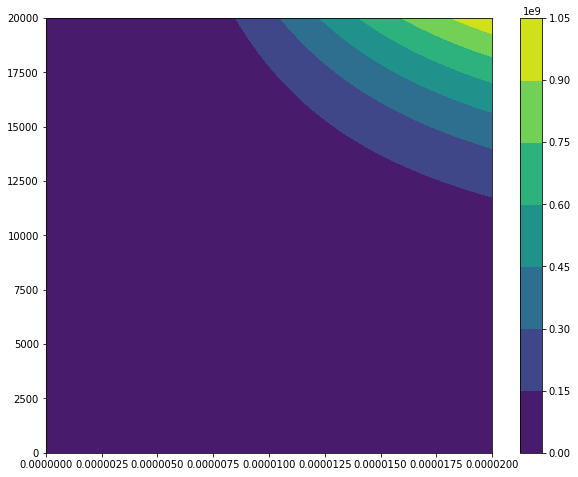

In [ ]:
# First plot of cost function, to get an idea of an init point for the optimization solver:
    #if show_figures:
beta_bar_vals = np.linspace(0,2e-5,100)  #beta_bar_vals = np.linspace(8e-6,12e-6,10)
S_bar_init_vals = np.linspace(0,2e4,100)   #S_bar_init_vals = np.linspace(8e3,10e3,10)
X,Y = np.meshgrid(beta_bar_vals,S_bar_init_vals)
Z = np.full((np.size(X,0),np.size(X,1)), np.nan)
for i in np.arange(0,np.size(X,0)):
     for j in np.arange(0,np.size(X,1)):
            #print(i,j)
            #[X[i,j],Y[i,j]]
            Z[i,j] = fun([X[i,j],Y[i,j]])
plt.figure(figsize=(10,8))
plt.contourf(X, Y, Z)
plt.colorbar()
plt.show()

In [69]:
# Define function for the estimation of beta_bar and S_bar_init:
def estimate_betabar_Sbarinit(H_init,tspan_train,data_totinout_train,c_HEL):  # estimation method with beta_bar and S_bar_init as optimization variables
    # Estimate gamma:
    gamma = estimate_gamma(tspan_train,data_totinout_train)
    fun = lambda x:phi(x,gamma,H_init,tspan_train,data_totinout_train,c_HEL)  # function phi is defined above
    beta_bar_guess, S_bar_init_guess = estimate_successive_betabar_Sbarinit(tspan_train,data_totinout_train)
    x_guess = [beta_bar_guess, S_bar_init_guess]
    x_opt = optimize.fmin(fun,x_guess)  # call the optimization solver
    beta_bar_opt = x_opt[0]
    S_bar_init_opt = x_opt[1]
    fun_opt = fun([beta_bar_opt,S_bar_init_opt])  # value of the minimum, useful for plot
    return (beta_bar_opt, S_bar_init_opt, gamma, fun_opt, fun, x_guess)

Optimization terminated successfully.
         Current function value: 5054929.473841
         Iterations: 80
         Function evaluations: 152
RMSE_train: 389.7854488858947 RMSE_test: 5411.975949479196 MAPE_test: 0.7768128615653638


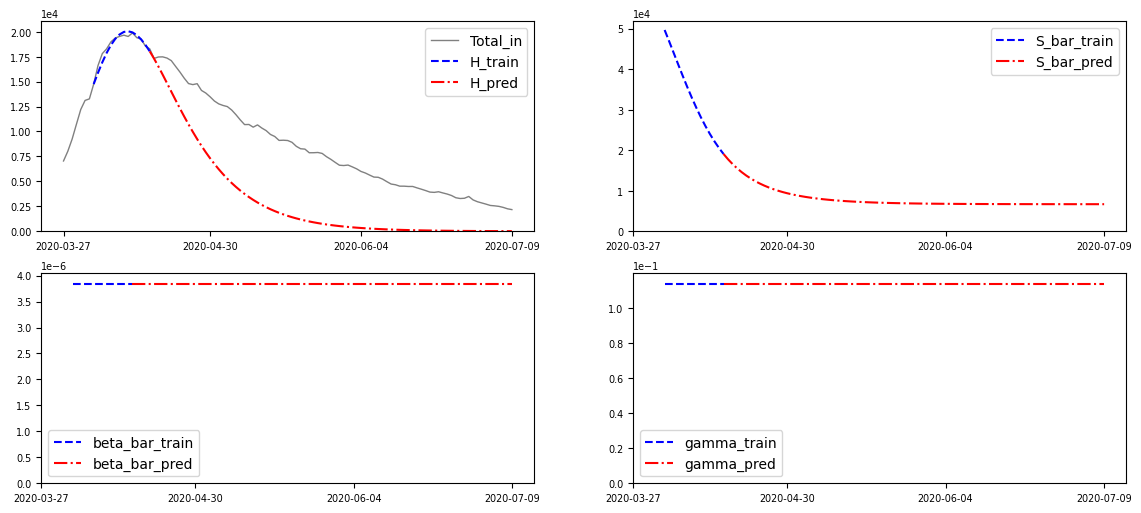

In [70]:
# Start loop on train periods:
plt.figure(figsize=(14,6))
for cnt_period in range(0, nb_periods):
    # Extract train variables for period cnt_period:
    train_t_start = train_t_start_vals[cnt_period]
    train_t_end = train_t_end_vals[cnt_period]
    test_t_end = test_t_end_vals[cnt_period]
    tspan_train = [train_t_start,train_t_end]
    # The test data is defined to be all the data that occurs from train_t_end.
    # Replace test data by NaN in *_train variables.
    data_totinout_train = copy.deepcopy(data_totinout)  # in order to be able to "hide" entries in data_totinout_train without changing data_totinout
    data_totinout_train[train_t_end:,:] = np.nan  # Beware that data_totinout_train has to be floats.
    # ! Make sure to use only these *_train variables in the train phase.
    H_init = data_totinout_train[tspan_train[0],0]

    # Estimate beta_bar and S_bar_init by optimizing the cost function:
    beta_bar_opt, S_bar_init_opt, gamma, fun_opt, fun, x_guess = estimate_betabar_Sbarinit(H_init,tspan_train,data_totinout_train,c_HEL)

    # Compute statistics:
    S_bar, H, E, L = simu(beta_bar_opt, gamma, S_bar_init_opt, H_init, tspan=[tspan_train[0],len(total_in)])
    RMSE_train = np.linalg.norm(H[train_t_start:train_t_end] - total_in[train_t_start:train_t_end]) / math.sqrt(train_t_end-train_t_start)
    RMSE_test = np.linalg.norm(H[train_t_end:test_t_end] - total_in[train_t_end:test_t_end]) / math.sqrt(test_t_end-train_t_end)
    MAPE_test=np.mean(np.abs( (total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end]) / total_in[train_t_end:test_t_end] ))
    print("RMSE_train:",RMSE_train, "RMSE_test:", RMSE_test, "MAPE_test:", MAPE_test)
    # Plot true and simulated H, and simulated S_bar:
    if show_figures:
         make_plots(beta_bar_opt,gamma,S_bar_init_opt,H_init,tspan_train,dates,data_totinout)
    #end if cnt_period

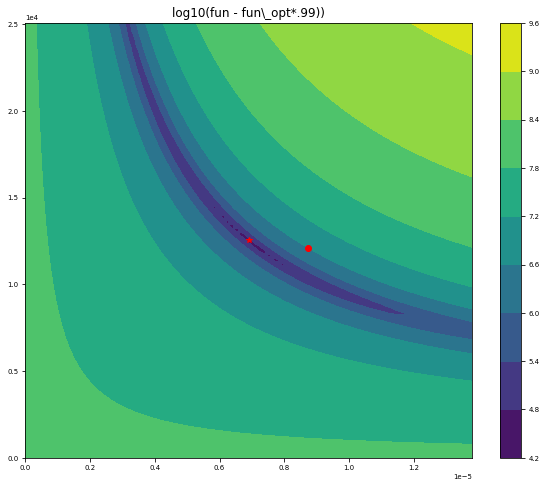

In [ ]:
#if show_figures:
# Plot the cost function around the found minimizer:
beta_bar_vals = np.linspace(0,beta_bar_opt*2,100)
S_bar_init_vals = np.linspace(0,S_bar_init_opt*2,100)
X,Y = np.meshgrid(beta_bar_vals,S_bar_init_vals)
Z = np.full((np.size(X,0),np.size(X,1)), np.nan)
for i in np.arange(0,np.size(X,0)):
     for j in np.arange(0,np.size(X,1)):
        Z[i,j] = math.log10(fun([X[i,j],Y[i,j]])-fun_opt*0.90)
fig=plt.figure(figsize=(10,8))
plt.contourf(X, Y, Z)
plt.colorbar()
plt.plot(x_guess[0],x_guess[1],'ro')  # show initial guess provided to optimization solver
plt.plot(beta_bar_opt,S_bar_init_opt,'r*')  # show point returned by optimization solver
plt.title('log10(fun - fun\_opt*.99))')
plt.ticklabel_format(style="sci", scilimits=(0,0))
plt.show(block=False)

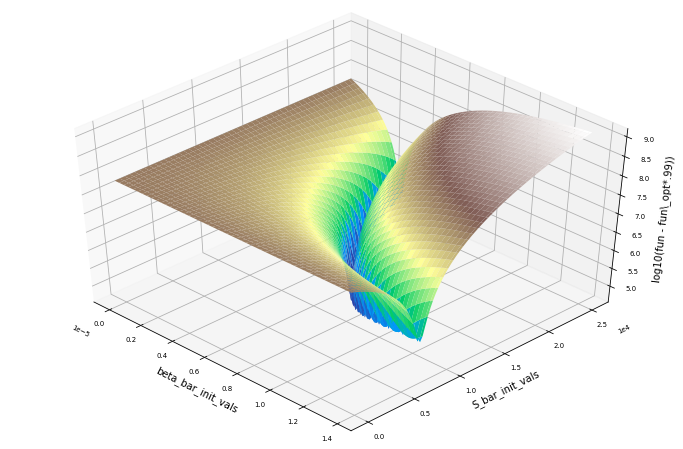

In [ ]:
#Global Optimization
from mpl_toolkits.mplot3d import Axes3D
beta_bar_vals = np.linspace(0,beta_bar_opt*2,100)
S_bar_init_vals = np.linspace(0,S_bar_init_opt*2,100)
X,Y = np.meshgrid(beta_bar_vals,S_bar_init_vals)

Z = np.full((np.size(X,0),np.size(X,1)), np.nan)
for i in np.arange(0,np.size(X,0)):
     for j in np.arange(0,np.size(X,1)):
        Z[i,j] = math.log10(fun([X[i,j],Y[i,j]])-fun_opt*0.90)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(X, Y, Z, cmap='terrain')

ax.set_xlabel('beta_bar_init_vals')
ax.set_ylabel('S_bar_init_vals')
ax.set_zlabel('log10(fun - fun\_opt*.99))')
ax.ticklabel_format(style="sci", scilimits=(0,0))
plt.show()
#fig.savefig('C:/Users/odiao/Desktop/Redaction_darticles_Latex/SHR_PA/Figures/minlocaux.pdf')   # save the figure to file
#plt.close(fig)

In [ ]:
#We now use the global optimizers to obtain the minimum and the function value at the minimum.
#We’ll store the results in a dictionary so we can compare different optimization results later.
print("optimize.fmin:",[beta_bar_opt,S_bar_init_opt]) #Initial method

bounds = [(0,beta_bar_opt*2), (0,S_bar_init_opt*2)] #Bounds for variables. (min, max) pairs for each element in x
results = dict()
results['shgo'] = optimize.shgo(fun, bounds) #shgo: Simplicial homology global optimisation
print("optimize.shgo:",results['shgo'].x)

results['DA'] = optimize.dual_annealing(fun, bounds)
print("optimize.dual_annealing:",results['DA'].x)

bounds = [(0,beta_bar_opt*4), (0,S_bar_init_opt)]
results['DE'] = optimize.differential_evolution(fun,bounds)
print("differential_evolution:",results['DE'].x)

results['BH'] = optimize.basinhopping(fun,bounds)
print("optimize.basinhopping:",results['BH'].x)

#shgo has a second method, which returns all local minima rather than only what it thinks is the global minimum:
results['shgo_sobol'] = optimize.shgo(fun, bounds, n=200, iters=20, sampling_method='sobol')
print("sampling_method='sobol':",results['shgo_sobol'].x)

optimize.fmin: [6.9000609725265814e-06, 12533.687517174572]
optimize.shgo: [6.90006097e-06 1.25336875e+04]
optimize.dual_annealing: [7.28867080e-06 1.19734519e+04]
differential_evolution: [6.91040437e-06 1.25172754e+04]
optimize.basinhopping: [1.03424000e+03 2.76002439e-05 0.00000000e+00 1.25336875e+04]
sampling_method='sobol': [7.26393138e-06 1.20134905e+04]


With optimize.shgo=optimize.fmin methode
RMSE_train: 76.34531440176235 RMSE_test: 65.94437299086474 MAPE_test 0.07403679218152436


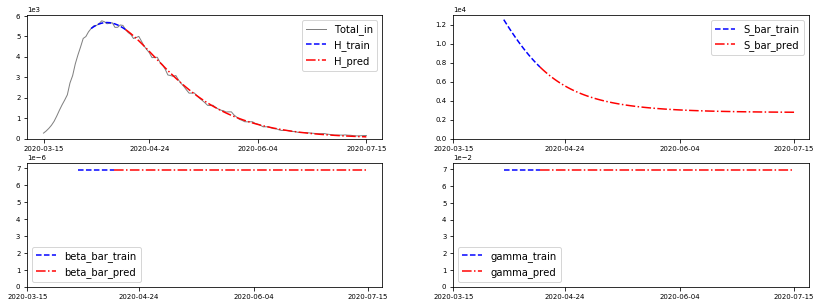

********************************************************************************
With optimize.differential_evolution methode
RMSE_train: 76.35510840116369 RMSE_test: 65.75464744731907 MAPE_test 0.07437995546931912


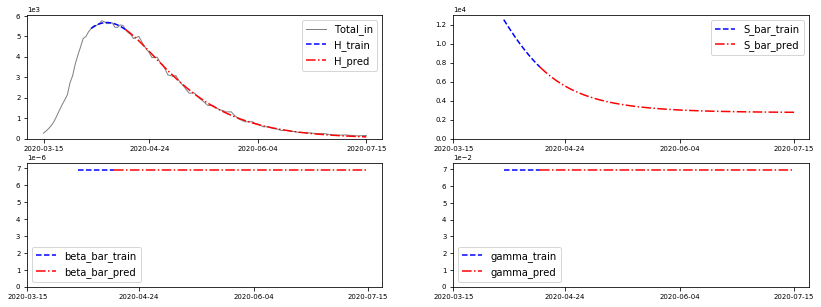

********************************************************************************
With optimize.basinhopping methode
RMSE_train: 4657.329744934083 RMSE_test: 706.6901726334611 MAPE_test 0.56161348019853


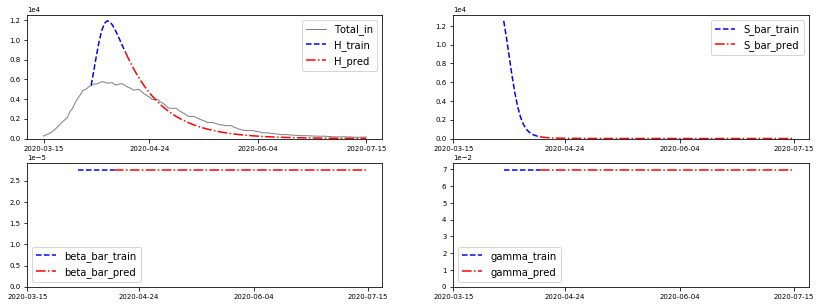

********************************************************************************
With optimize.dual_annealing method
RMSE_train: 77.39945006689639 RMSE_test: 78.06380809069415 MAPE_test 0.100849229931254


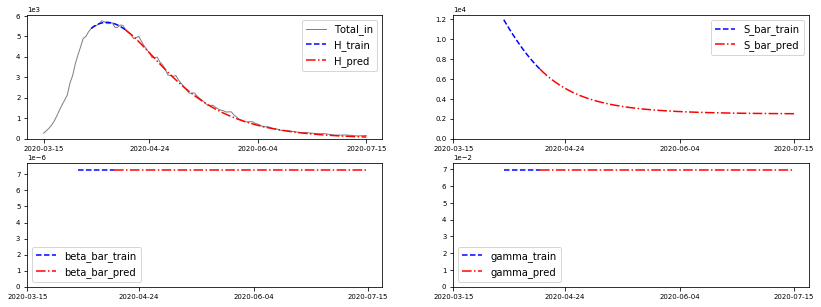

********************************************************************************
With optimize.shgo (....,sampling_method='sobol')
RMSE_train: 77.37135403763686 RMSE_test: 75.92078207923458 MAPE_test 0.09810591466027688


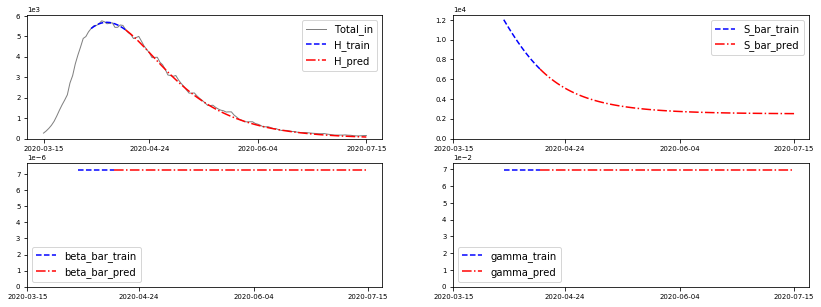

In [ ]:
#Tester les nouvelles valeurs de beta_bar et S_bar_init
# Start loop on train periods:
for cnt_period in range(0, nb_periods):
    # Extract train variables for period cnt_period:
    train_t_start = train_t_start_vals[cnt_period]
    train_t_end = train_t_end_vals[cnt_period]
    test_t_end = test_t_end_vals[cnt_period]
    tspan_train = [train_t_start,train_t_end]
    data_totinout_train = copy.deepcopy(data_totinout)  # in order to be able to "hide" entries in data_totinout_train without changing data_totinout
    data_totinout_train[train_t_end:,:] = np.nan  # Beware that data_totinout_train has to be floats.
    # ! Make sure to use only these *_train variables in the train phase.
    H_init = data_totinout_train[tspan_train[0],0]
    # Plots:
    plt.figure(figsize=(14,5))
    print("With optimize.shgo=optimize.fmin methode")
    S_bar, H, E, L = simu(results['shgo'].x[0], gamma, results['shgo'].x[1], H_init, tspan=[tspan_train[0],len(total_in)])
    RMSE_train = np.linalg.norm(H[train_t_start:train_t_end] - total_in[train_t_start:train_t_end]) / math.sqrt(train_t_end-train_t_start)
    RMSE_test = np.linalg.norm(H[train_t_end:test_t_end] - total_in[train_t_end:test_t_end]) / math.sqrt(test_t_end-train_t_end)
    MAPE_test=np.mean(np.abs( (total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end]) / total_in[train_t_end:test_t_end] ))
    print("RMSE_train:",RMSE_train, "RMSE_test:", RMSE_test, "MAPE_test", MAPE_test)
    if show_figures:
            make_plots(results['shgo'].x[0],gamma,results['shgo'].x[1],H_init,tspan_train,dates,data_totinout)
    plt.show()
    print("********************************************************************************")
    plt.figure(figsize=(14,5))
    print("With optimize.differential_evolution methode")
    S_bar, H, E, L = simu(results['DE'].x[0], gamma, results['DE'].x[1], H_init, tspan=[tspan_train[0],len(total_in)])
    RMSE_train = np.linalg.norm(H[train_t_start:train_t_end] - total_in[train_t_start:train_t_end]) / math.sqrt(train_t_end-train_t_start)
    RMSE_test = np.linalg.norm(H[train_t_end:test_t_end] - total_in[train_t_end:test_t_end]) / math.sqrt(test_t_end-train_t_end)
    MAPE_test=np.mean(np.abs( (total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end]) / total_in[train_t_end:test_t_end] ))
    print("RMSE_train:",RMSE_train, "RMSE_test:", RMSE_test, "MAPE_test", MAPE_test)
    if show_figures:
            make_plots(results['DE'].x[0],gamma,results['DE'].x[1],H_init,tspan_train,dates,data_totinout)
    plt.show()
    print("********************************************************************************")
    plt.figure(figsize=(14,5))
    print("With optimize.basinhopping methode")
    S_bar, H, E, L = simu(results['BH'].x[1], gamma, results['BH'].x[3], H_init, tspan=[tspan_train[0],len(total_in)])
    RMSE_train = np.linalg.norm(H[train_t_start:train_t_end] - total_in[train_t_start:train_t_end]) / math.sqrt(train_t_end-train_t_start)
    RMSE_test = np.linalg.norm(H[train_t_end:test_t_end] - total_in[train_t_end:test_t_end]) / math.sqrt(test_t_end-train_t_end)
    MAPE_test=np.mean(np.abs( (total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end]) / total_in[train_t_end:test_t_end] ))
    print("RMSE_train:",RMSE_train, "RMSE_test:", RMSE_test, "MAPE_test", MAPE_test)
    if show_figures:
            make_plots(results['BH'].x[1],gamma,results['BH'].x[3],H_init,tspan_train,dates,data_totinout)
    plt.show()
    print("********************************************************************************")
    plt.figure(figsize=(14,5))
    print("With optimize.dual_annealing method")
    S_bar, H, E, L = simu(results['DA'].x[0], gamma, results['DA'].x[1], H_init, tspan=[tspan_train[0],len(total_in)])
    RMSE_train = np.linalg.norm(H[train_t_start:train_t_end] - total_in[train_t_start:train_t_end]) / math.sqrt(train_t_end-train_t_start)
    RMSE_test = np.linalg.norm(H[train_t_end:test_t_end] - total_in[train_t_end:test_t_end]) / math.sqrt(test_t_end-train_t_end)
    MAPE_test=np.mean(np.abs( (total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end]) / total_in[train_t_end:test_t_end] ))
    print("RMSE_train:",RMSE_train, "RMSE_test:", RMSE_test, "MAPE_test", MAPE_test)
    if show_figures:
            make_plots(results['DA'].x[0],gamma,results['DA'].x[1],H_init,tspan_train,dates,data_totinout)
    plt.show()
    print("********************************************************************************")
    plt.figure(figsize=(14,5))
    print("With optimize.shgo (....,sampling_method='sobol')")
    S_bar, H, E, L = simu(results['shgo_sobol'].x[0], gamma, results['shgo_sobol'].x[1], H_init, tspan=[tspan_train[0],len(total_in)])
    RMSE_train = np.linalg.norm(H[train_t_start:train_t_end] - total_in[train_t_start:train_t_end]) / math.sqrt(train_t_end-train_t_start)
    RMSE_test = np.linalg.norm(H[train_t_end:test_t_end] - total_in[train_t_end:test_t_end]) / math.sqrt(test_t_end-train_t_end)
    MAPE_test=np.mean(np.abs( (total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end]) / total_in[train_t_end:test_t_end] ))
    print("RMSE_train:",RMSE_train, "RMSE_test:", RMSE_test, "MAPE_test", MAPE_test)
    if show_figures:
            make_plots(results['shgo_sobol'].x[0],gamma,results['shgo_sobol'].x[1],H_init,tspan_train,dates,data_totinout)
    plt.show()

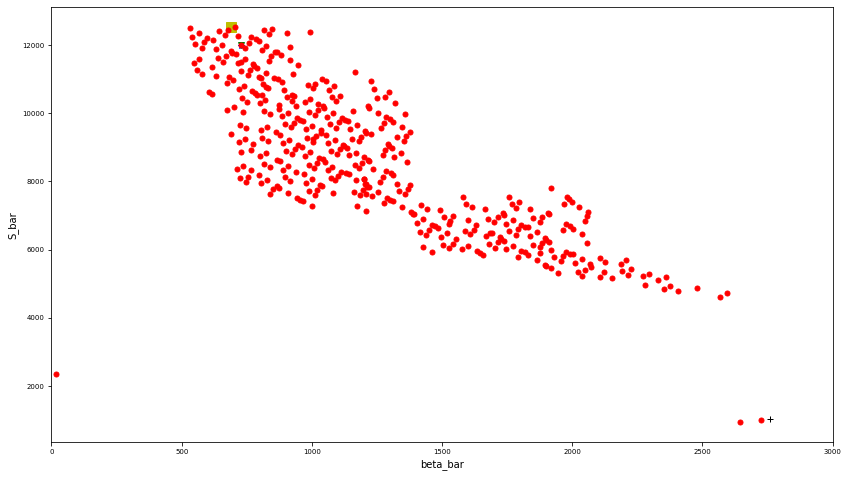

In [ ]:
#We’ll now plot all found minima on a heatmap of the function:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
#im = ax.imshow(Z, interpolation='bilinear', origin='lower', cmap='gray')
ax.set_xlabel('beta_bar')
ax.set_ylabel('S_bar')
#def plot_point(res, marker='o', color=None):
    #ax.plot(res.x[0]*100000000, res.x[1], marker=marker, color=color, ms=10)
#plot_point(results['BH'], color='y')  # basinhopping           - yellow
#plot_point(results['DE'], color='c')  # differential_evolution - cyan
#plot_point(results['DA'], color='b')  # dual_annealing.        - blue
ax.plot(results['BH'].x[1]*100000000,results['BH'].x[0], color='black', marker='+')  # basinhopping           - yellow
ax.plot(results['DE'].x[0]*100000000,results['DE'].x[1], color='c', marker='x')  # differential_evolution - cyan
ax.plot(results['DA'].x[0]*100000000,results['DA'].x[1], color='b',marker='*')  # dual_annealing.        - blue

# SHGO produces multiple minima, plot them all (with a smaller marker size)
ax.plot(results['shgo'].x[0]*100000000,results['shgo'].x[1], 'ys',ms=10)
ax.plot(results['shgo_sobol'].x[0]*100000000, results['shgo_sobol'].x[1],color='g', marker='v')
for i in range(results['shgo_sobol'].xl.shape[0]):
     ax.plot(results['shgo_sobol'].xl[i, 0]*100000000,
             results['shgo_sobol'].xl[i, 1],'ro', ms=5)

ax.set_xlim([0, 3000])
#ax.set_ylim([0, 50000])
plt.show()

Optimization terminated successfully.
         Current function value: 5054929.473841
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 4791185.166879
         Iterations: 121
         Function evaluations: 228
RMSE_train: 821.8192404689302 RMSE_test: 5239.928291500893 MAPE_test 0.7620029561161561


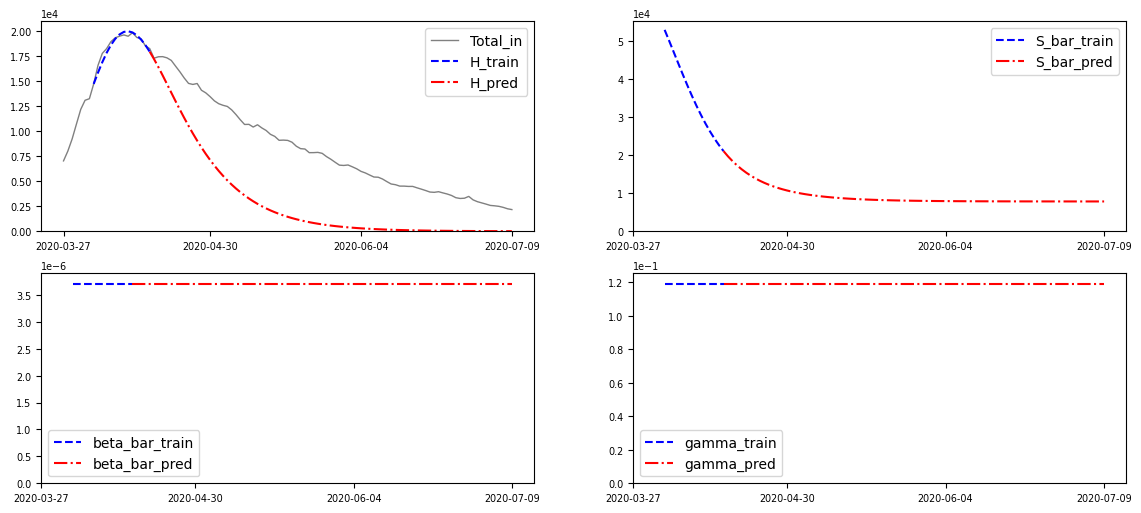

In [71]:
def phi_gamma(x,H_init,tspan_train,data_totinout_train,c_HEL):  #x := [beta_bar,S_bar_init,gamma]
    return phi_basic(x[0],x[2],x[1],H_init,tspan_train,data_totinout_train,c_HEL)

# Define function for the estimation of beta_bar, S_bar_init, and gamma:
def estimate_betabar_Sbarinit_gamma(H_init,tspan_train,data_totinout_train,c_HEL):
    fun_gamma = lambda x:phi_gamma(x,H_init,tspan_train,data_totinout_train,c_HEL)
    beta_bar_guess, S_bar_init_guess, gamma_guess, _, _, _ = estimate_betabar_Sbarinit(H_init,tspan_train,data_totinout_train,c_HEL)
    x_guess_gamma = [beta_bar_guess,S_bar_init_guess,gamma_guess]       #[x_opt,gamma_hat_RM]  # sugg: [x_opt,gamma_hat_RM]
    x_opt_gamma = optimize.fmin(fun_gamma,x_guess_gamma)  # call the optimization solver
    beta_bar_opt_gamma = x_opt_gamma[0]
    S_bar_init_opt_gamma = x_opt_gamma[1]
    gamma_opt_gamma = x_opt_gamma[2]
    return (beta_bar_opt_gamma, S_bar_init_opt_gamma, gamma_opt_gamma)
# Start loop on train periods:
plt.figure(figsize=(14,6))
for cnt_period in range(0, nb_periods):
    # Extract train variables for period cnt_period:
    train_t_start = train_t_start_vals[cnt_period]
    train_t_end = train_t_end_vals[cnt_period]
    test_t_end = test_t_end_vals[cnt_period]
    tspan_train = [train_t_start,train_t_end]
    # The test data is defined to be all the data that occurs from train_t_end.
    # Replace test data by NaN in *_train variables.
    data_totinout_train = copy.deepcopy(data_totinout)  # in order to be able to "hide" entries in data_totinout_train without changing data_totinout
    data_totinout_train[train_t_end:,:] = np.nan  # Beware that data_totinout_train has to be floats.
    # ! Make sure to use only these *_train variables in the train phase.
    H_init = data_totinout_train[tspan_train[0],0]

    # Estimate beta_bar, S_bar_init, and gamma:
    beta_bar_opt_gamma, S_bar_init_opt_gamma, gamma_opt_gamma = estimate_betabar_Sbarinit_gamma(H_init,tspan_train,data_totinout_train,c_HEL)
    S_bar, H, E, L = simu(beta_bar_opt_gamma, gamma, S_bar_init_opt_gamma, H_init, tspan=[tspan_train[0],len(total_in)])
    RMSE_train = np.linalg.norm(H[train_t_start:train_t_end] - total_in[train_t_start:train_t_end]) / math.sqrt(train_t_end-train_t_start)
    RMSE_test = np.linalg.norm(H[train_t_end:test_t_end] - total_in[train_t_end:test_t_end]) / math.sqrt(test_t_end-train_t_end)
    MAPE_test=np.mean(np.abs( (total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end]) / total_in[train_t_end:test_t_end] ))
    print("RMSE_train:",RMSE_train, "RMSE_test:", RMSE_test, "MAPE_test", MAPE_test)
    # (Here we no longer plot the cost function because there are now 3 optimization variables.
    # Plot true and simulated H, and simulated S_bar:
    if show_figures:
        make_plots(beta_bar_opt_gamma,gamma_opt_gamma,S_bar_init_opt_gamma,H_init,tspan_train,dates,data_totinout)

Optimization terminated successfully.
         Current function value: 5054929.473841
         Iterations: 80
         Function evaluations: 152
Optimization terminated successfully.
         Current function value: 4791185.166879
         Iterations: 121
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: 3732932.653848
         Iterations: 209
         Function evaluations: 380
RMSE_train: 282.6686213421741 RMSE_test: 5224.466296370713 MAPE_test 0.7606802948401802


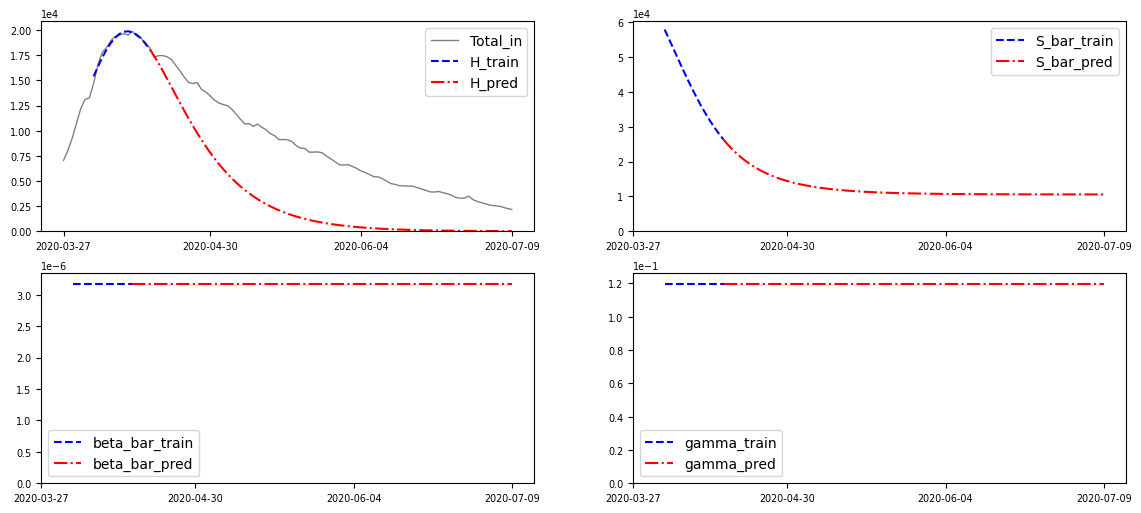

In [72]:
def phi_gammaHinit(x,tspan_train,data_totinout_train,c_HEL):   # x := [beta_bar,S_bar_init,gamma,H_init]
        return phi_basic(x[0],x[2],x[1],x[3],tspan_train,data_totinout_train,c_HEL)

    #if show_figures:
fig=plt.figure(figsize=(14,6))
# Start loop on train periods:
for cnt_period in range(0, nb_periods):

    # Extract train variables for period cnt_period:
    train_t_start = train_t_start_vals[cnt_period]
    train_t_end = train_t_end_vals[cnt_period]
    test_t_end = test_t_end_vals[cnt_period]
    tspan_train = [train_t_start,train_t_end]
    # The test data is defined to be all the data that occurs from train_t_end.
    # Replace test data by NaN in *_train variables.
    data_totinout_train = copy.deepcopy(data_totinout)  # in order to be able to "hide" entries in data_totinout_train without changing data_totinout
    data_totinout_train[train_t_end:,:] = np.nan  # Beware that data_totinout_train has to be floats.
    # ! Make sure to use only these *_train variables in the train phase.
    H_init = data_totinout_train[tspan_train[0],0]

    # Estimate beta_bar, S_bar_init, gamma, and H_init (no need to encapsulate it in a function):
    fun_gammaHinit = lambda x:phi_gammaHinit(x,tspan_train,data_totinout_train,c_HEL)  # function phi is given at the end of this script
    beta_bar_guess, S_bar_init_guess, gamma_guess = estimate_betabar_Sbarinit_gamma(H_init,tspan_train,data_totinout_train,c_HEL)
    x_guess_gammaHinit = [beta_bar_guess, S_bar_init_guess,gamma_guess,H_init]
    x_opt_gammaHinit = optimize.fmin(fun_gammaHinit,x_guess_gammaHinit)  # call the optimization solver
    beta_bar_opt_gammaHinit = x_opt_gammaHinit[0]
    S_bar_init_opt_gammaHinit = x_opt_gammaHinit[1]
    gamma_opt_gammaHinit = x_opt_gammaHinit[2]
    H_init_opt_gammaHinit = x_opt_gammaHinit[3]
    S_bar, H, E, L = simu(beta_bar_opt_gammaHinit, gamma_opt_gammaHinit, S_bar_init_opt_gammaHinit, H_init_opt_gammaHinit, tspan=[tspan_train[0],len(total_in)])
    RMSE_train = np.linalg.norm(H[train_t_start:train_t_end] - total_in[train_t_start:train_t_end]) / math.sqrt(train_t_end-train_t_start)
    RMSE_test = np.linalg.norm(H[train_t_end:test_t_end] - total_in[train_t_end:test_t_end]) / math.sqrt(test_t_end-train_t_end)
    MAPE_test=np.mean(np.abs( (total_in[train_t_end:test_t_end]-H[train_t_end:test_t_end]) / total_in[train_t_end:test_t_end] ))
    print("RMSE_train:",RMSE_train, "RMSE_test:", RMSE_test, "MAPE_test", MAPE_test)
    # Compute statistics:

    # Plot true and simulated H, and simulated S_bar:
    if show_figures:
        make_plots(beta_bar_opt_gammaHinit,gamma_opt_gammaHinit,S_bar_init_opt_gammaHinit,H_init_opt_gammaHinit,tspan_train,dates,data_totinout)


No handles with labels found to put in legend.


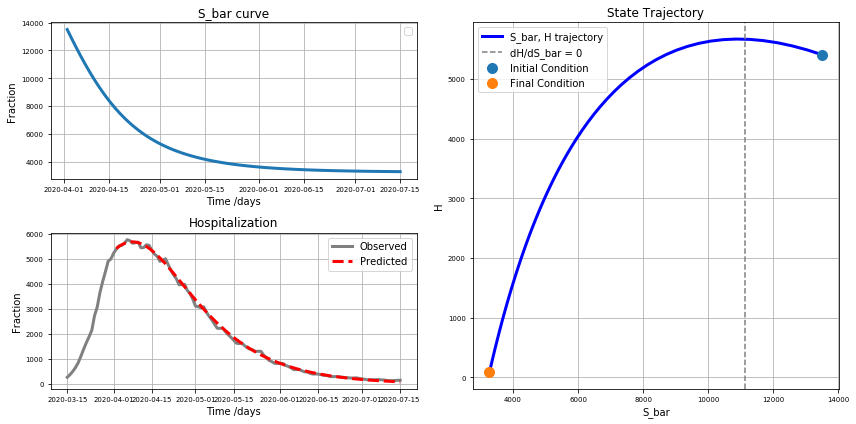

In [ ]:
#Phase portrait
def plotdata(dates, S_bar, H):

    fig = plt.figure(figsize=(12,6))
    ax = [fig.add_subplot(221, axisbelow=True),
          fig.add_subplot(223),
          fig.add_subplot(122)]

    ax[0].plot(dates, S_bar, lw=3)
    ax[0].set_title('S_bar curve')
    ax[0].set_xlabel('Time /days')
    ax[0].set_ylabel('Fraction')

    ax[1].plot(dates, total_in, 'grey',lw=3, label="Observed")
    ax[1].plot(dates, H,'r--', lw=3, label="Predicted")
    ax[1].set_title('Hospitalization')
    #ax[1].set_ylim(0, 0.3)
    ax[1].set_xlabel('Time /days')
    ax[1].set_ylabel('Fraction')

    ax[2].plot(S_bar, H, 'b',lw=3,label='S_bar, H trajectory')
    plt.axvline(x=gamma_opt_gammaHinit/beta_bar_opt_gammaHinit, color='gray',linestyle='--',label='dH/dS_bar = 0')
    #plt.plot([gamma/beta_bar,5672.20224212], [0, 1], '--', lw=3, label='dH/dt = 0') #5672.20224212 is the H_max
    plt.plot(S_bar[tspan_train[0]], H[tspan_train[0]], '.', ms=20, label='Initial Condition')
    #plt.text(S_bar[tspan_train[0]], H[tspan_train[0]], 'initial')
    plt.plot(S_bar[-1], H[-1], '.', ms=20, label='Final Condition')
    #plt.text(S_bar[-1], H[-1],'final')
    plt.xlabel("S_bar")
    plt.ylabel("H")
    plt.title('State Trajectory')

    for a in ax:
        a.grid(True)
        a.legend()

    plt.tight_layout()


S_bar, H, E, L = simu(beta_bar_opt_gammaHinit, gamma_opt_gammaHinit, S_bar_init_opt_gammaHinit, H_init_opt_gammaHinit,tspan=[tspan_train[0],len(total_in)])
plotdata(dates, S_bar, H)

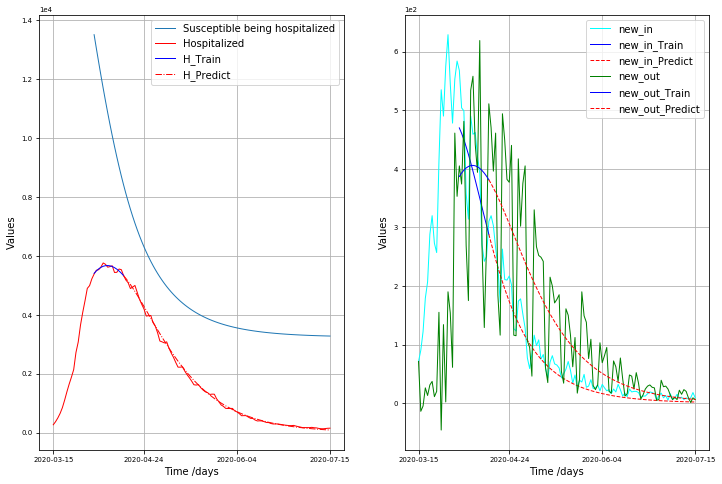

In [ ]:
#Phase portrait
fig = plt.figure(figsize=(12,8))
def plots(dates, S_bar, H):

    nb_xticks = 4
    dates_ticks = [None] * nb_xticks
    dates_ticks_ind = np.linspace(0,len(total_in)-1,nb_xticks,dtype=int)
    for i in range(0,nb_xticks):
        dates_ticks[i] = dates[dates_ticks_ind[i]]

    plt.subplot(121)
    plt.plot(dates, S_bar, lw=1, label="Susceptible being hospitalized")

    plt.plot(dates, total_in, 'r',lw=1, label="Hospitalized")
    plt.plot(dates[train_t_start:train_t_end],H[train_t_start:train_t_end],'blue',lw=1,label="H_Train")
    plt.plot(dates[train_t_end-1:test_t_end],H[train_t_end-1:test_t_end],'r-.',lw=1, label="H_Predict")

    plt.xticks(dates_ticks)
    plt.xlabel('Time /days')
    plt.ylabel('Values')
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(dates, new_in, 'cyan',lw=1, label="new_in")
    plt.plot(dates[train_t_start:train_t_end], E[train_t_start:train_t_end], 'blue',lw=1, label="new_in_Train")
    plt.plot(dates[train_t_end-1:test_t_end], E[train_t_end-1:test_t_end], 'r--',lw=1, label="new_in_Predict")

    plt.plot(dates, new_out, 'green',lw=1, label="new_out")
    plt.plot(dates[train_t_start:train_t_end], L[train_t_start:train_t_end], 'blue',lw=1, label="new_out_Train")
    plt.plot(dates[train_t_end-1:test_t_end], L[train_t_end-1:test_t_end], 'r--',lw=1, label="new_out_Predict")

    plt.xticks(dates_ticks)
    plt.xlabel('Time /days')
    plt.ylabel('Values')
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.legend()
    plt.grid()

S_bar, H, E, L = simu(beta_bar_opt_gammaHinit, gamma_opt_gammaHinit, S_bar_init_opt_gammaHinit, H_init_opt_gammaHinit,tspan=[tspan_train[0],len(total_in)])
plots(dates, S_bar, H)
plt.show()
#fig.savefig('C:/Users/odiao/Desktop/Submit to CDD/Epreuve de confirmation Ousmane/Figures/model_2021_04_19.pdf')   # save the figure to file
#plt.close(fig)

In [ ]:
#Phase portrait with variable initial conditions

def Phase_portrait_plots(beta_bar,gamma):
    plt.figure(figsize=(10,6))
    S_bar_init=[0.98,0.95,0.9,0.8,0.7,0.6,0.5,0.5,0.4,0.4,0.35,0.3,0.2]
    H_init=[0.02,0.05,0.1,0.02,0.3,0.015,0.5,0.01,0.05,0.6,0.65,0.7,0.8]
    for i in np.arange(0,len(S_bar_init)):
        #H_init = np.full(len(S_bar_init), np.nan)  # set storage
        #H_init[i]= 1.0-S_bar_init[i]
        S_bar, H, E, L = simu(beta_bar, gamma, S_bar_init[i], H_init[i],tspan=[tspan_train[0],len(total_in)])
        plt.plot(S_bar, H,lw=2, color='black')
        plt.plot(S_bar[tspan_train[0]], H[tspan_train[0]], 'r.', ms=10)
        #plt.text(S_bar[tspan_train[0]], H[tspan_train[0]], 'initial')
        plt.plot(S_bar[-1], H[-1], 'b.', ms=10)
    plt.plot([1,0])
    plt.xlabel("S_bar")
    plt.ylabel("H")
    plt.title('State Trajectory')
    plt.axis([0., 1., 0., 1.])
    plt.legend(['Trajectory','Initial Condition','Final condition'])  #['R0_bar=',beta_bar/gamma]

w = interactive(Phase_portrait_plots,beta_bar=np.linspace(10**-2, 5*10**-1,20), gamma=np.linspace(1/20,1/2,20))
display(w)

plt.show()


interactive(children=(Dropdown(description='beta_bar', options=(0.01, 0.035789473684210524, 0.0615789473684210…

In [ ]:
#Phase portrait with variable initial conditions

def H_plots(S_bar_init,beta_bar,gamma):
    plt.figure(figsize=(10,6))
    S_bar, H, E, L = simu(beta_bar, gamma, S_bar_init, H_init_opt_gammaHinit,tspan=[tspan_train[0],len(total_in)])
    plt.plot(dates, H, 'r--',lw=2, label="Predicted data")
    plt.plot(dates, total_in, 'gray', lw=2,label="Observed data")
    plt.xlabel("Times")
    plt.ylabel("H")
    plt.legend()
    #plt.title('State Trajectory')

w = interactive(H_plots,S_bar_init=np.arange(3200,14000,50),beta_bar=[4.31769172e-07, 1.86353834e-06, 3.29530752e-06,
                                                                    4.72707669e-06, 6.15884586e-06, beta_bar_opt_gammaHinit,
                                                                    7.59061503e-06, 9.02238420e-06, 9.5e-06,1e-05],
                                                                    gamma=[0.04, 0.06,gamma_opt_gammaHinit,0.08, 0.1 , 0.12, 0.14, 0.16, 0.18,0.2])
display(w)

plt.show()

interactive(children=(Dropdown(description='S_bar_init', options=(3200, 3250, 3300, 3350, 3400, 3450, 3500, 35…

In [ ]:
#Phase portrait with variable initial conditions
def plots(S_bar_init, H_init, beta_bar, gamma):
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    S_bar, H, E, L = simu(beta_bar, gamma, S_bar_init, H_init,tspan=[tspan_train[0],len(total_in)])
    #plt.plot(dates, H, 'r--',lw=3, label="Predicted data")
    plt.plot(dates, total_in, 'gray',label="Observed data")
    plt.plot(dates[train_t_start:train_t_end],H[train_t_start:train_t_end],'blue',lw=1,label="H_Train")
    plt.plot(dates[train_t_end-1:test_t_end],H[train_t_end-1:test_t_end],'r-.',lw=1, label="H_Predict")
    plt.xlabel("Times")
    plt.ylabel("H")
    plt.legend()

    plt.subplot(122)
    plt.plot(S_bar, H,lw=2, color='black')
    plt.plot(S_bar[tspan_train[0]], H[tspan_train[0]], 'r.', ms=10)
    #plt.text(S_bar[tspan_train[0]], H[tspan_train[0]], 'initial')
    plt.plot(S_bar[-1], H[-1], 'b.', ms=10)
    plt.xlabel("S_bar")
    plt.ylabel("H")
    plt.title('State Trajectory')
    plt.legend(['Trajectory','Initial Condition','Final condition'])

w = interactive(plots,S_bar_init=np.linspace(3200,14000,25), H_init=np.linspace(100,6000,25),
                      beta_bar=[4.31769172e-07, 1.86353834e-06, 3.29530752e-06,
                                4.72707669e-06, 6.15884586e-06, beta_bar_opt_gammaHinit,7.59061503e-06, 9.02238420e-06],
                      gamma=[0.04, 0.06,gamma_opt_gammaHinit,0.08, 0.1 , 0.12, 0.14, 0.16, 0.18,0.2])

display(w)
plt.show()

interactive(children=(Dropdown(description='S_bar_init', options=(3200.0, 3650.0, 4100.0, 4550.0, 5000.0, 5450…

In [ ]:
print(beta_bar_opt_gammaHinit)
print(gamma_opt_gammaHinit)
print(S_bar_init_opt_gammaHinit)
print(H_init_opt_gammaHinit)

6.431769171994548e-06
0.07155237932610219
13509.900776243143
5407.546315058275


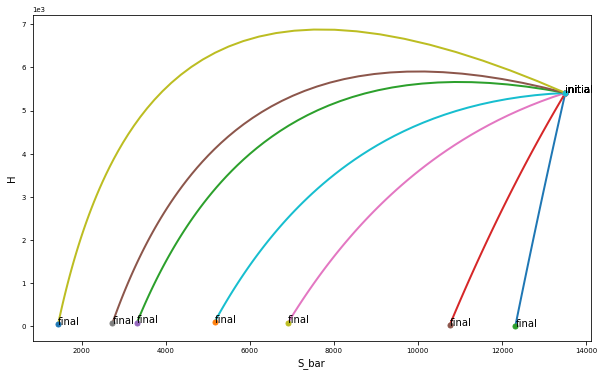

In [ ]:
#Phase portrait
beta_bar_vals=[10**-6,2*10**-6, 4*10**-6, 5*10**-6, 6.4*10**-6, 7*10**-6,9*10**-6]
plt.figure(figsize=(10,6))
for beta_bar in beta_bar_vals:
        S_bar, H, E, L = simu(beta_bar, gamma_opt_gammaHinit, S_bar_init_opt_gammaHinit, H_init_opt_gammaHinit, tspan=[tspan_train[0],len(total_in)])
        plt.plot(S_bar, H, lw=2)
        #plt.axvline(x=gamma/beta_bar, color='gray',linestyle='--')
        plt.plot(S_bar[tspan_train[0]], H[tspan_train[0]], '.', ms=10)
        plt.text(S_bar[tspan_train[0]], H[tspan_train[0]], 'initial')
        plt.plot(S_bar[-1], H[-1], '.', ms=10)
        plt.text(S_bar[-1], H[-1],'final')
        plt.xlabel("S_bar")
        plt.ylabel("H")
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        #plt.title('State Trajectory')
#plt.legend(['Initial Condition','Final Condition'])
plt.show()

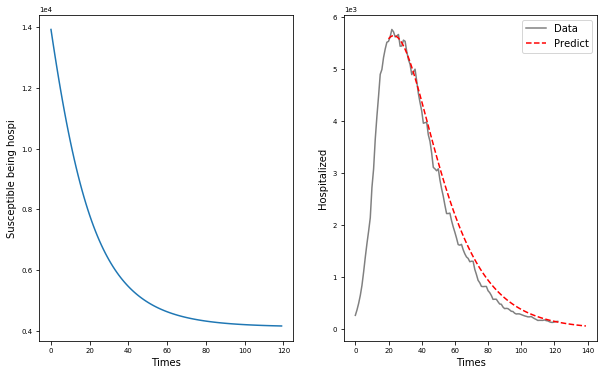

In [ ]:
from scipy.integrate import odeint
from math import *

beta_bar=beta_bar_opt_gammaHinit
gamma=gamma_opt_gammaHinit
S_bar0=S_bar_init_opt_gammaHinit
H0=H_init_opt_gammaHinit

#t = np.linspace(0, 120, 1000)
t = np.arange(0, 120)

def S_barIR_bar(y, t, beta_bar, gamma):
        S_bar, H = y
        dS_bar_dt = -beta_bar*S_bar*H
        dH_dt = beta_bar*S_bar*H -gamma*H
        return([dS_bar_dt, dH_dt])
#result
solution = odeint(S_barIR_bar, [S_bar0, H0], t, args = (beta_bar, gamma))
solution = np.array(solution)
#plot result for humans
plt.figure(figsize = [10, 6])

plt.subplot(121)
plt.plot(t, solution[:, 0])
plt.ylabel("Susceptible being hospi")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel("Times")

plt.subplot(122)
plt.plot(total_in, 'grey', label="Data")
plt.plot(t+tspan_train[0], solution[:, 1], 'r--', label="Predict")
plt.ylabel("Hospitalized")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel("Times")

plt.legend()
plt.show()

In [ ]:
#Phase portrait with variable initial conditions

def Phase_plots(beta_bar,gamma):
    plt.figure(figsize=(12,6))
    S_bar0=0.98
    H0=0.02

    for p in np.linspace(0.0, 1.0, 10):
        #result
        sol = odeint(S_barIR_bar, [S_bar0-p, H0+p], t, args = (beta_bar, gamma))
        sol = np.array(sol)
        plt.plot(sol[:, 0], sol[:, 1],lw=1, color='black')
        plt.plot(sol[0,0], sol[0,1], 'r.', ms=10)
        #plt.text(S_bar[tspan_train[0]], H[tspan_train[0]], 'initial')
        plt.plot(sol[-1,0], sol[-1,1], 'b.', ms=10)

    plt.plot([1.0,0.0])
    plt.xlabel("S_bar")
    plt.ylabel("H")
    plt.title('State Trajectory')
    plt.axis([0., 1., 0., 1.])
    plt.legend(['Trajectories','Initial Condition','Final condition'])

w = interactive(Phase_plots,beta_bar=np.linspace(10**-3, 10**-1,20), gamma=np.linspace(1/20,1/2,20))
display(w)

plt.show()

interactive(children=(Dropdown(description='beta_bar', options=(0.001, 0.006210526315789474, 0.011421052631578…

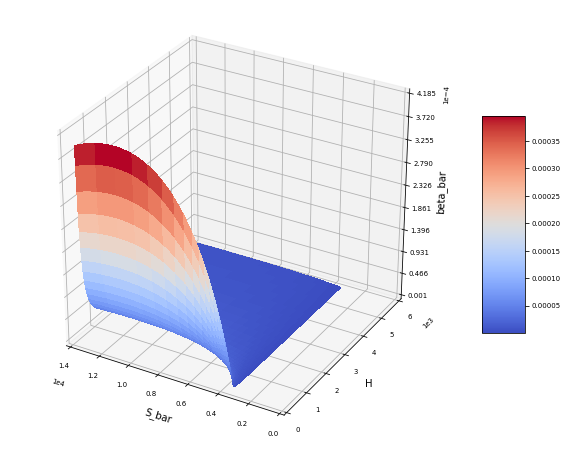

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

S_bar, H, E, L = simu(beta_bar_opt_gammaHinit, gamma_opt_gammaHinit, S_bar_init_opt_gammaHinit, H_init_opt_gammaHinit,tspan=[tspan_train[0],len(total_in)])
#S_bar=np.linspace(0,14000,100)
#H=np.linspace(0,6000,100)
#E=np.linspace(0, np.max(E),100)
S_bar, H = np.meshgrid(S_bar[tspan_train[0]:], H[tspan_train[0]:])
beta_bar_chapo=E[tspan_train[0]:]/(S_bar*H)
#print(beta_bar_chapo)

fig = plt.figure(figsize = [10, 8])
ax = fig.gca(projection='3d')
ax.set_xlim(14000, 0)
ax.set_ylim(0, 6000)
#plt.title("")
ax.set_xlabel("S_bar")
ax.set_ylabel("H")
ax.set_zlabel("beta_bar")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.ticklabel_format(axis="z", style="sci", scilimits=(0,0))

surf=ax.plot_surface(S_bar, H, beta_bar_chapo, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
